In [6]:
import numpy as np
import matplotlib.pyplot as plt
    

        

In [204]:
def psi(n,x):
    N = np.zeros(n+1)
    N[n] = 1
    H = np.polynomial.hermite.Hermite(N)
    Norm = 2**(-0.5 * n) * np.pi**-0.25 * (np.math.factorial(n))**-0.5 
    wf = Norm * np.exp(-x**2/2) * H(x)
    return wf

class Solver_Herm:
    def __init__(self,L1,L2,h,n_herm,V,T):
        self.L1 = L1
        self.L2 = L2
        self.h = h
        self.N = int((L2-L1) / h)
        self.V = V
        self.T = T
        self.n_herm = n_herm
        self.x = np.arange(L1,L2,h)
        self.p=(2*np.pi/self.h) * np.fft.fftfreq(self.x.shape[0])
        self.H = np.zeros((self.n_herm,self.n_herm))
        self.values = np.zeros((self.n_herm))
        self.vectors_herm = np.zeros((self.n_herm,self.n_herm))
        self.vectors_x = np.zeros((self.n_herm,self.N))
        self.vectors_p = np.zeros((self.n_herm,self.N))
        self.PSI = np.array([psi(n,self.x) for n in range(self.n_herm)])
        
    def op_H(self,F_x):
        F_p = np.fft.fft(F_x)
        p = (2*np.pi/self.h) * np.fft.fftfreq(F_x.shape[0])
        TF_p = self.T(p) * F_p
        TF_x = np.fft.ifft(TF_p).real
        HF=TF_x + self.V(self.x) * F_x
        return HF
        
    
    def compute_H(self):
        I=np.eye(self.n_herm)
        for i in range(self.n_herm):
            for j in range(self.n_herm):
                self.H[i][j] = self.h * np.dot(self.PSI[i],self.op_H(self.PSI[j]))
        return self
    
    def compute_eigen(self):
        E = np.linalg.eigh(self.H)
        self.values = E[0]
        self.vectors_herm = np.transpose(E[1])
        return self
    
    def x_rep(self):
        self.vectors_x = np.dot(self.vectors_herm,self.PSI)
        return self
    
    def p_rep(self):
        PSI_p = self.h *(2*np.pi)**-0.5 * np.fft.fft(self.PSI,axis=1)
        self.vectors_p = np.dot(self.vectors_herm,PSI_p)
        return self
        
    def compute_all(self):
        self.compute_H().compute_eigen().x_rep().p_rep()
        return self
    
    def mean_x(self,f,n=0):
        F = f(self.x)
        psi_x = self.vectors_x[n]
        return self.h * np.dot(psi_x**2,F)
    
    def mean_p(self,f,n=0):
        F = f(self.p)
        psi_p = self.vectors_p[n]
        return (2*np.pi/(self.L2-self.L1)) * np.dot(np.abs(psi_p)**2,F)
    
    def get_rho(self,beta):
        E = np.exp(-beta*(self.values-self.values[0]))
        rho = np.dot(E,self.vectors_x**2)/np.sum(E)
        return rho
    
    def log_Z(self,beta):
        return np.log(np.sum(np.exp(-beta*self.values)))
    
    def plot(self,n):
        fig=plt.figure()
        plt.grid(True)
        plt.plot(self.x,self.vectors_x[n])
        plt.show()

In [176]:
def T(p):
    return p**2/2

def T_rel(p):
    return (1+p**2)**0.5

In [177]:
def x2(x):
    return x**2

In [178]:
def V_osc(x):
    return x**2 / 2

In [179]:
def one(x):
    return np.ones((x.shape[0]))

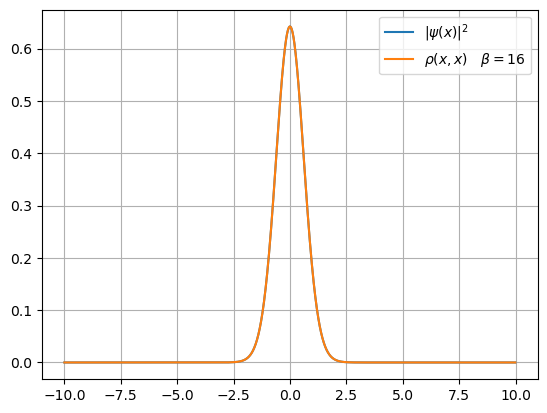

<x^2>= 0.4003612767822719
<T>= 1.240871651205587
<V>= 0.20018063839113595


In [181]:
solv = Solver_Herm(-10,10,0.01,30,V_osc,T_rel)
solv.compute_all()
plt.figure()
plt.grid(True)
plt.plot(solv.x,solv.vectors_x[0]**2)
plt.plot(solv.x,solv.get_rho(16))
plt.legend([r"$|\psi(x)|^2$",r"$\rho(x,x) \quad \beta=16$"])
plt.show()
print("<x^2>=",solv.mean_x(x2))
print("<T>=",solv.mean_p(T_rel))
print("<V>=",solv.mean_x(V_osc))

In [182]:
from math import gamma
def get_V_morse(alpha):
    def V_morse(x):
        y = np.exp(-alpha * x)-1
        return 0.5*(y**2-1)
    return V

def theor_Psi2(alpha,x):
        N = 2**(2 / alpha - 1) * (2-alpha)/( (alpha ** (2/alpha - 1)) * gamma(2/alpha))
        power = (-2 / alpha) * np.exp(-alpha * x) - (2-alpha) * x
        P=N*np.exp(power)
        return P


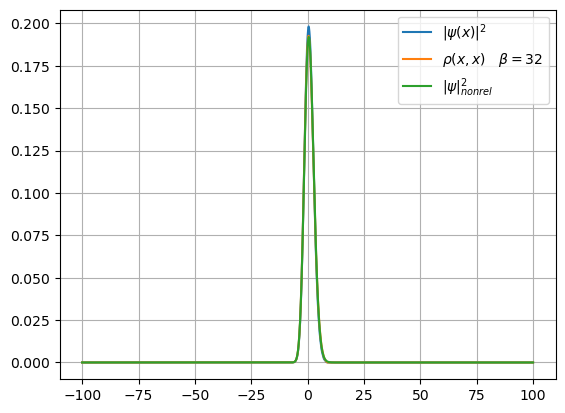

<x^2>= 4.648165006366928
<T>= 1.0299605232213513
<V>= -0.47047075064754423


In [203]:
alpha=0.125
V=get_V_morse(alpha)
solv = Solver_Herm(-100,100,0.01,40,V,T_rel)
solv.compute_all()

plt.figure()
plt.grid(True)
plt.plot(solv.x,solv.vectors_x[0]**2)
plt.plot(solv.x,solv.get_rho(32))
plt.plot(solv.x,theor_Psi2(alpha,solv.x))
plt.legend([r"$|\psi(x)|^2$",r"$\rho(x,x) \quad \beta=32$",r"$|\psi|^2_{nonrel}$"])
plt.show()

print("<x^2>=",solv.mean_x(x2))
print("<T>=",solv.mean_p(T_rel))
print("<V>=",solv.mean_x(V))

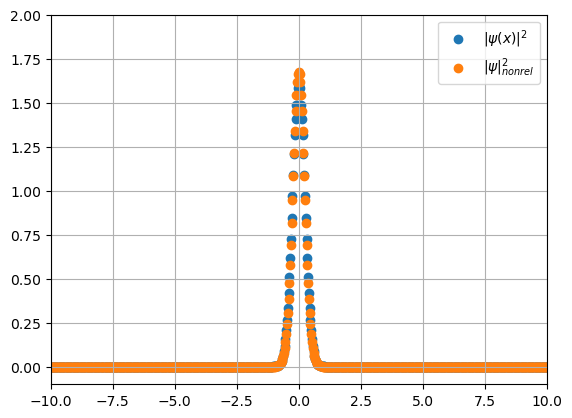

In [199]:
tpsi2_p = solv.h *(2*np.pi)**-0.5 * np.fft.fft(theor_Psi2(alpha,solv.x)**0.5)
plt.figure()
plt.grid(True)
plt.scatter(solv.p,np.abs(solv.vectors_p[0])**2)
plt.scatter(solv.p,np.abs(tpsi2_p)**2)
plt.legend([r"$|\psi(x)|^2$",r"$|\psi|^2_{nonrel}$"])
plt.axis([-10,10,-0.1,2])
plt.show()

При $\alpha=0.5$, $\alpha=1$ численное решение с нерелятивистской кинетической энергией не совпадает с точным. Число дискретных уровней

$N(\alpha)=[\frac{2-\alpha}{2\alpha}]+1$


$N(1)=1 \qquad N(0.5)=2 \qquad N(0.125)=8$

Доверять численному решению можно при $\alpha=0.125$

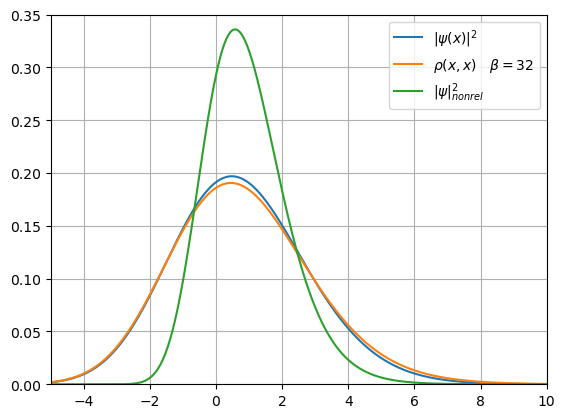

<x^2>= 4.8071871554775605
<T>= 12.932025862288672
<V>= -0.46998744414292326
0.5593183579396119


In [119]:
alpha = 0.5
V=get_V_morse(alpha)
solv = Solver_Herm(-50,200,0.005,90,V,T_rel)
solv.compute_all()

plt.figure()
plt.grid(True)
plt.plot(solv.x,solv.vectors_x[0]**2)
plt.plot(solv.x,solv.get_rho(32))
plt.plot(solv.x,theor_Psi2(alpha,solv.x))
plt.axis([-5,10,0,0.35])
plt.legend([r"$|\psi(x)|^2$",r"$\rho(x,x) \quad \beta=32$",r"$|\psi|^2_{nonrel}$"])
plt.show()

print("<x^2>=",solv.mean_x(x2))
print("<T>=",solv.mean_p(T_rel))
print("<V>=",solv.mean_x(V))

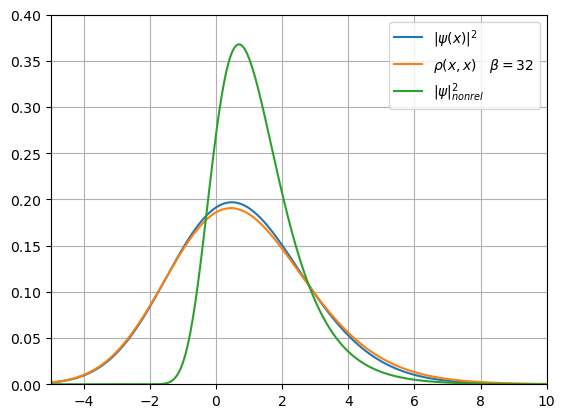

<x^2>= 4.8071871554775605
<T>= 12.932025862288672
<V>= -0.46998744414292326


In [122]:
alpha=1
V = get_V_morse(alpha)
solv = Solver_Herm(-50,200,0.005,90,V,T_rel)
solv.compute_all()

plt.figure()
plt.grid(True)
plt.plot(solv.x,solv.vectors_x[0]**2)
plt.plot(solv.x,solv.get_rho(32))
plt.plot(solv.x,theor_Psi2(alpha,solv.x))
plt.axis([-5,10,0,0.4])
plt.legend([r"$|\psi(x)|^2$",r"$\rho(x,x) \quad \beta=32$",r"$|\psi|^2_{nonrel}$"])
plt.show()


print("<x^2>=",solv.mean_x(x2))
print("<T>=",solv.mean_p(T_rel))
print("<V>=",solv.mean_x(V))

In [129]:
def V_tw(x):
    x0=1.41
    return (x**2-x0**2)**2

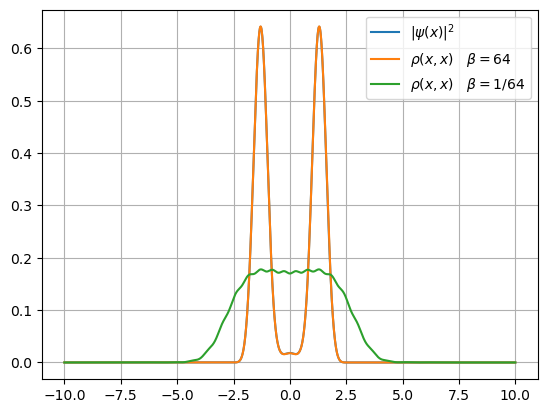

-2.314364272822012
<x^2>= 1.7446455506720089
<T>= 1.6738778111330437
<V>= 0.7178165855429578


In [208]:
solv = Solver_Herm(-10,10,0.005,20,V_tw,T_rel)
solv.compute_all()

plt.figure()
plt.grid(True)
plt.plot(solv.x,solv.vectors_x[0]**2)
plt.plot(solv.x,solv.get_rho(64))
plt.plot(solv.x,solv.get_rho(1/64))
plt.legend([r"$|\psi(x)|^2$",r"$\rho(x,x) \quad \beta=64$",r"$\rho(x,x) \quad \beta=1/64$"])
plt.show()

print(-solv.log_Z(1/64))

print("<x^2>=",solv.mean_x(x2))
print("<T>=",solv.mean_p(T_rel))
print("<V>=",solv.mean_x(V_tw))